In [1]:
!pip install emcee corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00


In [2]:
from scipy import stats
from scipy import optimize
from scipy.stats import norm, uniform
import numpy as np
import pylab as plt
import emcee
import corner

In [3]:
mass, eventpermassbin, eventerr = np.loadtxt('boson.txt',unpack=True)

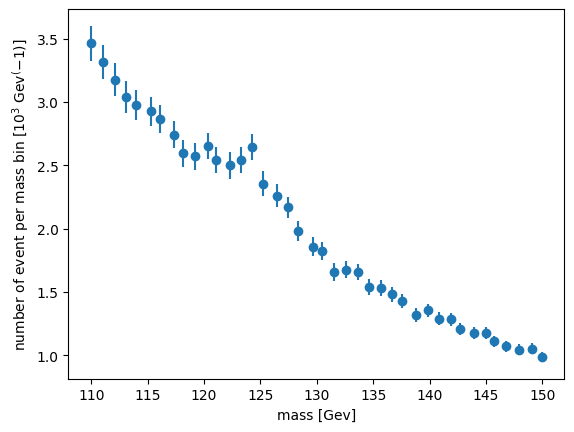

In [4]:
plt.errorbar(mass, eventpermassbin, eventerr,fmt='o')

plt.xlabel('mass [Gev]')

plt.ylabel('number of event per mass bin [$10^3$ Gev$^(-1)$]');

#Model Definition

In [132]:
def model(mass, bg_amp, bg_exp, signal_amp, signal_mean, signal_width):
  background = bg_amp * (mass/110) ** (-bg_exp)
  signal = signal_amp * np.exp(-0.5 * ((mass - signal_mean) / signal_width) ** 2)

  return background + signal

def log_likelihood(params, mass, eventpermassbin, eventerr):
  bg_amp, bg_exp, signal_amp, signal_mean, signal_width = params
  if bg_amp <= 0 or signal_width <= 0 or signal_amp < 0:
        return -np.inf

  model_counts = model(mass, bg_amp, bg_exp, signal_amp, signal_mean, signal_width)
  return -0.5 * np.sum(((eventpermassbin - model_counts) / eventerr) ** 2 + np.log(2 * np.pi * eventerr**2))

def log_prior(params):
  bg_amp, bg_exp, signal_amp, signal_mean, signal_width = params

  if (1 < bg_amp < 5 and
        1 < bg_exp < 5 and
        0 < signal_amp < 2 and
        120 < signal_mean < 130 and
        0 < signal_width < 5):
        return 0.0

  return -np.inf

def log_posterior(params, mass, eventpermassbin, eventerr):
  if not np.isfinite(log_prior(params)):
    return -np.inf

  return log_prior(params) + log_likelihood(params, mass, eventpermassbin, eventerr)

#MCMC

In [133]:
def plot_chain(samples, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, :, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

def plot_chain_flattened(chain, labels):
  ndim = len(labels)
  plt.figure(figsize=(14, 10))
  for i, label in enumerate(labels):
    plt.subplot(ndim, 1, i+1)
    plt.plot(samples[:, i], alpha=0.3)
    plt.ylabel(label)
    plt.tight_layout()

In [134]:
ndim = 5
nwalkers = 10
nsteps = 10000

initial_bg_amp = uniform.rvs(loc=.1, scale=4, size=nwalkers)
initial_bg_exp = uniform.rvs(loc=1, scale=3.5, size=nwalkers)
initial_signal_amp = uniform.rvs(loc=.1, scale=1.5, size=nwalkers)
initial_signal_mean = uniform.rvs(loc=120, scale=10, size=nwalkers)
initial_signal_width = uniform.rvs(loc=0, scale=5, size=nwalkers)

initial_positions = np.column_stack([initial_bg_amp, initial_bg_exp, initial_signal_amp, initial_signal_mean, initial_signal_width])

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(mass, eventpermassbin, eventerr)
)
sampler.run_mcmc(initial_positions, nsteps, progress=True)


100%|██████████| 10000/10000 [00:09<00:00, 1000.02it/s]


State([[  3.50157029   3.94826949   0.3413909  124.60696851   2.82179286]
 [  3.43806197   3.98417761   0.33848064 124.07226135   3.84656484]
 [  3.49722217   4.05265575   0.3262407  124.251137     2.57951333]
 [  3.53541737   4.05007982   0.44249588 124.53739504   2.48205572]
 [  3.40499508   3.90020092   0.3999329  123.66252292   2.72396414]
 [  3.46706555   4.0144469    0.39375416 124.55646793   2.78756461]
 [  3.42368773   3.93822715   0.39272695 123.97749818   2.98655958]
 [  3.61626576   4.25199299   0.3290865  123.89218163   2.32436443]
 [  3.44469737   3.96721964   0.34431035 124.26363588   3.61428962]
 [  3.54575095   4.10409406   0.2723074  124.46901666   2.98587894]], log_prob=[58.32434615 60.36510098 59.90718114 59.64514261 60.01414823 61.41456218
 61.41996383 52.77953579 60.76127165 58.73682366], blobs=None, random_state=('MT19937', array([2993822271, 4201877590, 3430760285, 3636817249, 1154602735,
       1290957222,  822987677, 3637306596, 3172369867, 3110012211,
       4

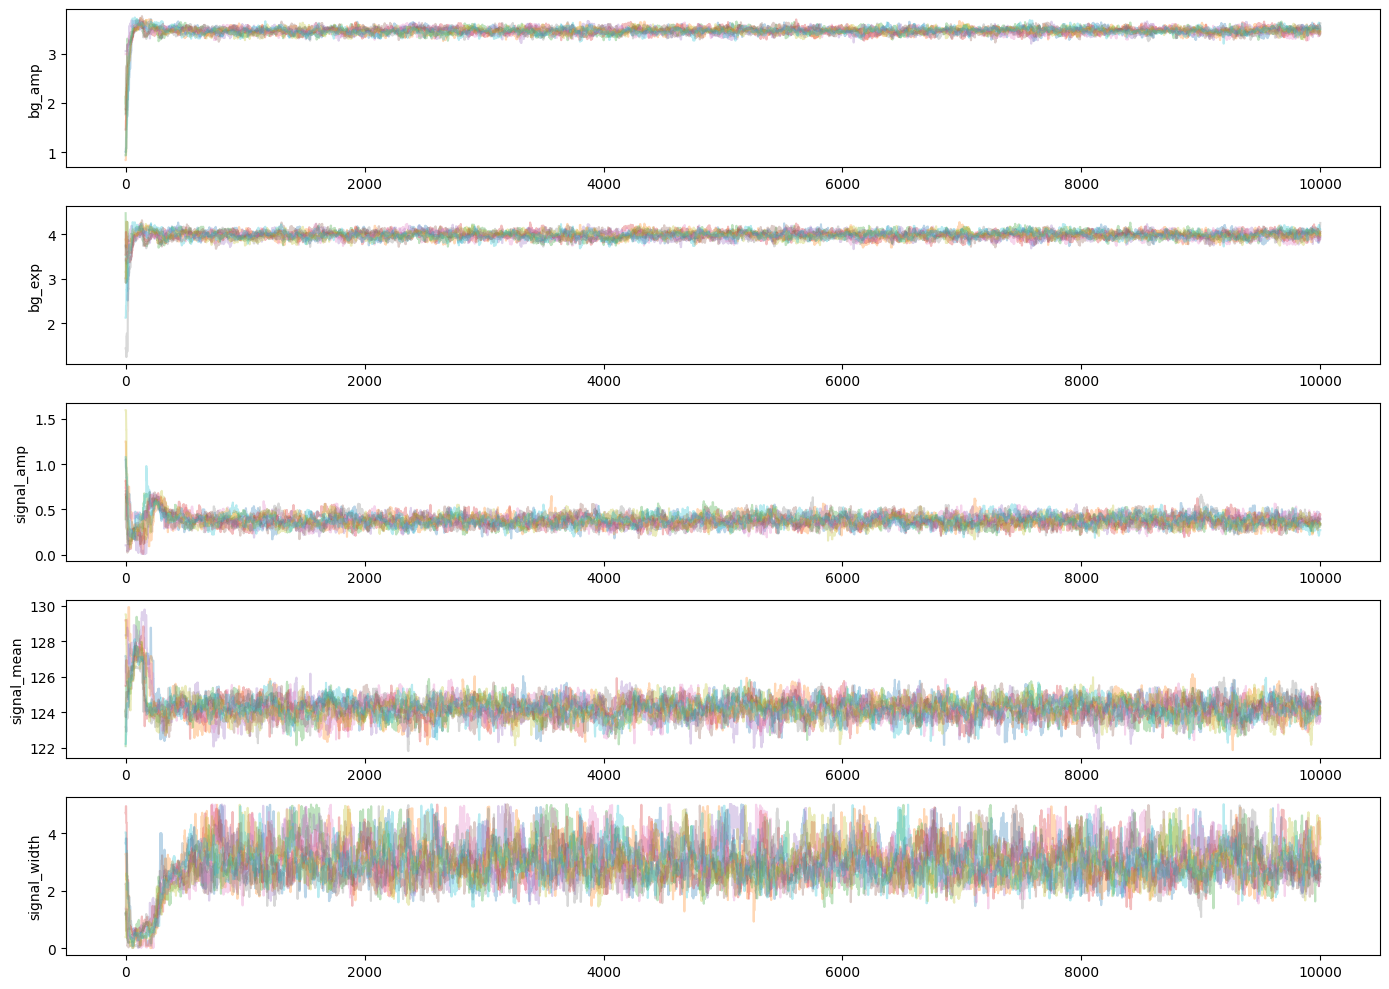

In [135]:
labels = ["bg_amp", "bg_exp", "signal_amp", "signal_mean", "signal_width"]
plot_chain(sampler.get_chain(), labels)

Now I will run the MCMC with more steps



In [136]:
nsteps = 100000

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(mass, eventpermassbin, eventerr)
)
sampler.run_mcmc(initial_positions, nsteps, progress=True)


100%|██████████| 100000/100000 [01:37<00:00, 1021.97it/s]


State([[  3.48683815   3.99583598   0.39203198 124.67070787   2.39924191]
 [  3.53469249   4.03748363   0.28023612 124.54465354   3.46920373]
 [  3.45494524   3.97270806   0.41182642 124.05410453   2.85804056]
 [  3.4617466    3.95792861   0.44125511 124.49939036   2.60443533]
 [  3.45888251   3.97191026   0.3519753  124.94902718   3.58199023]
 [  3.39119037   3.93673761   0.37522722 123.16550847   3.69877238]
 [  3.51510544   4.02825216   0.3447068  124.32278376   2.41567277]
 [  3.41140629   3.92769155   0.38320559 124.41556739   3.70405601]
 [  3.49630886   4.06027983   0.35705348 124.98396189   3.13576012]
 [  3.38192561   3.93420994   0.42002235 124.30367369   3.48835794]], log_prob=[61.11424954 58.41215367 61.54525017 60.78038006 58.80559293 58.94000812
 60.75803952 59.82928828 59.85555111 59.77641738], blobs=None, random_state=('MT19937', array([3626681953, 2228539201, 2696155803,   23717268,  267473804,
       2684390888, 2592869435, 3044030642, 2722151992,  977234376,
        

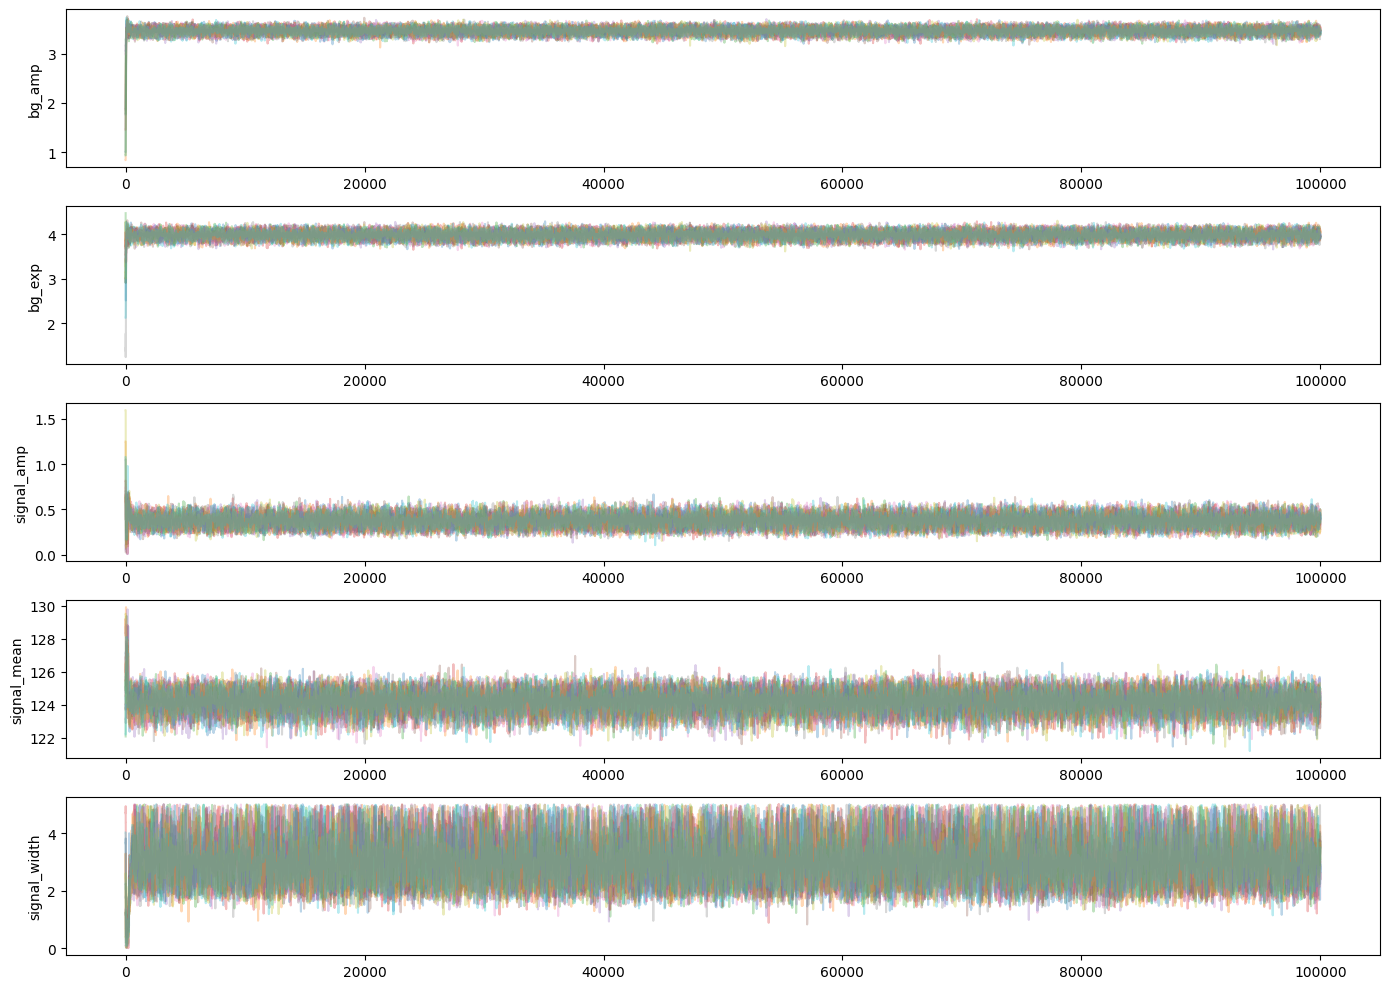

In [137]:
plot_chain(sampler.get_chain(), labels)

In [138]:
tau = sampler.get_autocorr_time()
print(f"Autocorrelation times: {tau}")
burnin = 30000
thin = int(np.max(tau) / 2)

print(f"Burn-in: {burnin} steps")
print(f"Thin: {thin} steps")

Autocorrelation times: [68.6530253  70.95029729 73.22065868 75.42402377 87.94447652]
Burn-in: 30000 steps
Thin: 43 steps


In [139]:
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Number of samples after burn-in and thinning: {len(samples)}")

Number of samples after burn-in and thinning: 16270


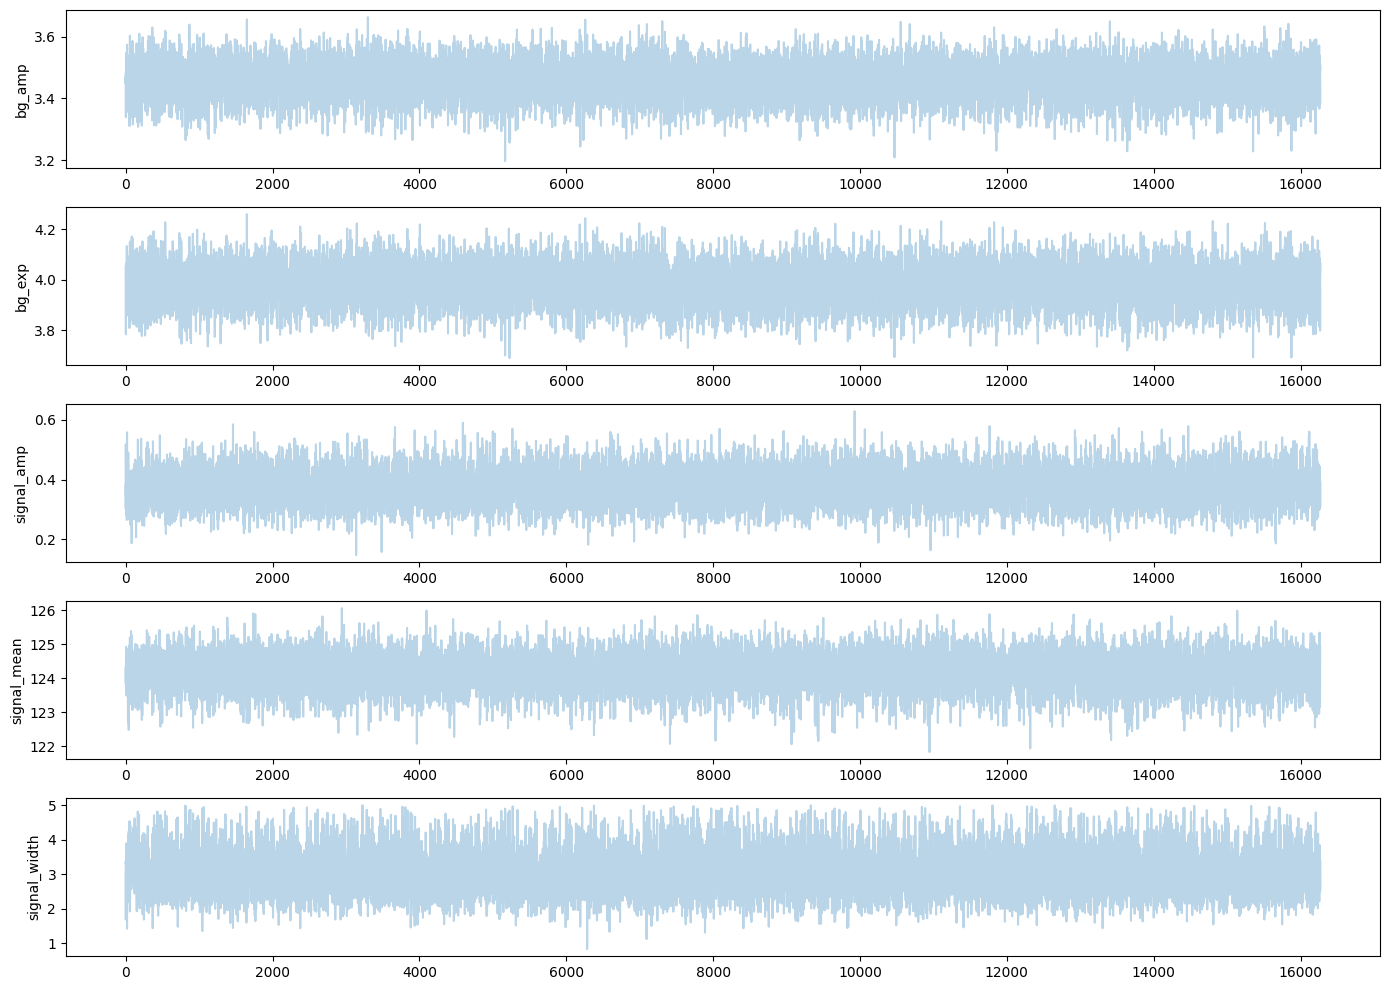

In [140]:
plot_chain_flattened(samples, labels)

##Corner Plot of parameters

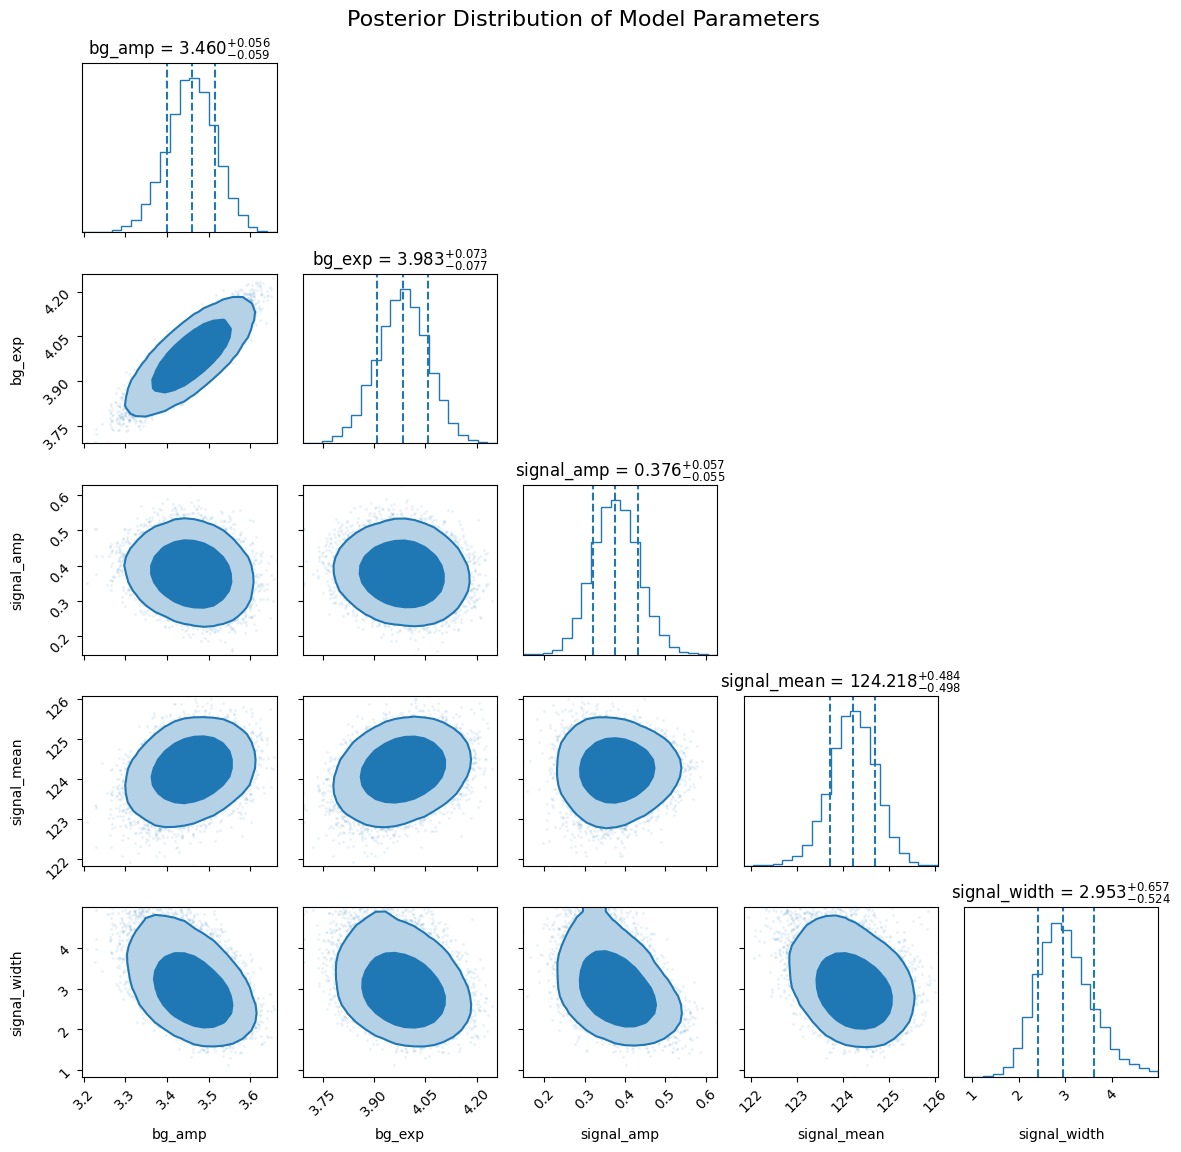

In [141]:
fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  # 16%, 50% (median), and 84% quantiles
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt=".3f",
    levels=[0.68, 0.95],  # 68% and 95% credible levels
    smooth=1.0,
    plot_datapoints=True,
    plot_density=True,
    fill_contours=True,
    color='#1f77b4',
  )

fig.suptitle("Posterior Distribution of Model Parameters", fontsize=16)
plt.tight_layout()

##Median estimated model plot


In [142]:
bg_amp_median = np.median(samples[:, 0])
bg_exp_median = np.median(samples[:, 1])
signal_amp_median = np.median(samples[:, 2])
signal_mean_median = np.median(samples[:, 3])
signal_width_median = np.median(samples[:, 4])

print("\nMedian parameter values from MCMC:")
print(f"Background amplitude: {bg_amp_median:.2f}")
print(f"Background exponent: {bg_exp_median:.2f}")
print(f"Signal amplitude: {signal_amp_median:.2f}")
print(f"Signal mean (Higgs mass): {signal_mean_median:.2f} GeV")
print(f"Signal width: {signal_width_median:.2f} GeV")


Median parameter values from MCMC:
Background amplitude: 3.46
Background exponent: 3.98
Signal amplitude: 0.38
Signal mean (Higgs mass): 124.22 GeV
Signal width: 2.95 GeV


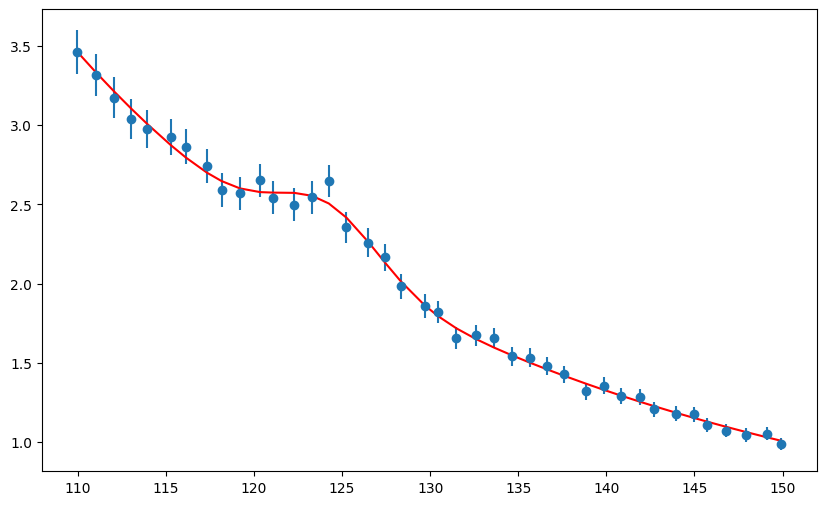

In [143]:
# Plot the data with model fit
plt.figure(figsize=(10, 6))
plt.errorbar(mass, eventpermassbin, yerr=eventerr, fmt='o', label='Data')

# Plot the median model
median_model = model(
    mass, bg_amp_median, bg_exp_median,
    signal_amp_median, signal_mean_median, signal_width_median
)
plt.plot(mass, median_model, 'r-', label='Full model')

Clearly, the signal is absent when the signal amplitude is zero, in this case the median signal amplitude estimated via MCMC is 0.38, hence we can state the there might be signal in the data

#Density estimation of signal amplitude parameter

In [166]:
signal_amp_samples = samples[:, 2]

In [167]:
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(signal_amp_samples.min(),signal_amp_samples.max(),1000)

def kde_sklearn(data, bandwidth = 1.0, kernel="gaussian"):
    kde_skl = KernelDensity(bandwidth = bandwidth,
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])

    return np.exp(log_pdf)

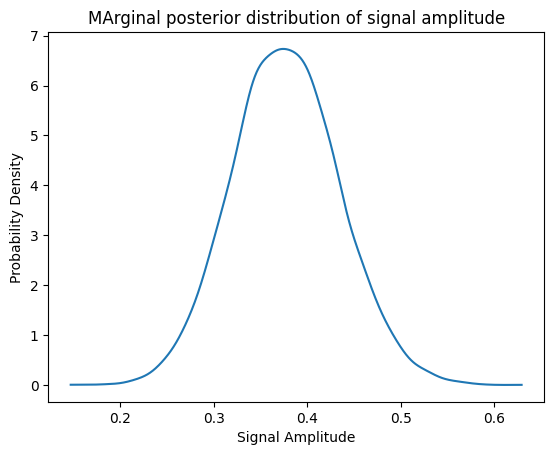

In [173]:
pdf_signal_amp = kde_sklearn(signal_amp_samples, bandwidth=.01, kernel='gaussian')


plt.figure()
plt.plot(xgrid, pdf_signal_amp)
plt.xlabel("Signal Amplitude")
plt.ylabel("Probability Density")
plt.title("MArginal posterior distribution of signal amplitude")
plt.show()

#Bayes Factor

In [179]:
posterior_at_zero = pdf_signal_amp[0]

In [181]:
# as prior I used a uniforn distribution between 0 and 2
prior_at_zero = 1/2

In [185]:
bayes_factor =  prior_at_zero / posterior_at_zero
print(f'Bayes Factor computed through Savage-Dickey approximation: {bayes_factor}')

Bayes Factor computed through Savage-Dickey approximation: 109.35002027619299


Being the Bayes factor > 100, according to the Jeffrey's scale, we have a decisive evidence for the presence of the Higgs boson in the data